In [1]:
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import jax.numpy as jnp
import optax
import jax
import numpy as np
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,
    IndependenceCouplingSampler,build_trainloader,testloader_factory)
from stochastic_interpolant.loss_functions import get_linear_interpolants,root_prod_gamma,root_prod_gammadot,get_loss_functions
from stochastic_interpolant.data_generators import inf_train_gen
from stochastic_interpolant.model_training import train_model

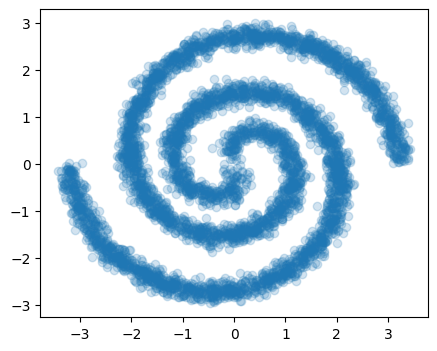

In [2]:
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)
plt.figure(figsize=(5,4))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.2)
plt.show()

In [3]:
I,It = get_linear_interpolants()
gamma = root_prod_gamma
gammadot = root_prod_gammadot
loss_b,loss_denoise = get_loss_functions(I,It,gamma,gammadot)

b_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(21239)
)
eta_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(30238)
)

data_coupling_sampler = IndependenceCouplingSampler(
    GaussianReferenceSampler((2,)),
    DatasetSampler(target_samples)
    )
batch_size = 1024

train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
test_factory = testloader_factory(batch_size,jax.random.PRNGKey(32498130),data_coupling_sampler)

In [4]:
b_optim = optax.nadamw(4e-4)

b_model,b_loss_history = train_model(
  model = b_model,
  optim = b_optim,
  steps = 100000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_b,
  print_every = 5000,
  num_testloader_batches = 100,
)


  0%|          | 0/100000 [00:00<?, ?it/s]

step=0 | train_loss=-0.009510778 | test_loss= -0.47715452
step=5000 | train_loss=-1.5457193 | test_loss= -1.3738717
step=10000 | train_loss=-1.4376376 | test_loss= -1.5541722
step=15000 | train_loss=-1.5464857 | test_loss= -1.6561704
step=20000 | train_loss=-1.2658546 | test_loss= -1.7259903
step=25000 | train_loss=-1.9299753 | test_loss= -1.7669734
step=30000 | train_loss=-1.563246 | test_loss= -1.792369
step=35000 | train_loss=-2.5996366 | test_loss= -1.8184104
step=40000 | train_loss=-2.0886073 | test_loss= -1.851742
step=45000 | train_loss=-1.442654 | test_loss= -1.8721026
step=50000 | train_loss=-1.9637562 | test_loss= -1.9047972
step=55000 | train_loss=-1.8932412 | test_loss= -1.8710345
step=60000 | train_loss=-1.6362448 | test_loss= -1.9332228
step=65000 | train_loss=-1.6641678 | test_loss= -1.9123608
step=70000 | train_loss=-2.2086182 | test_loss= -1.938009
step=75000 | train_loss=-1.7567303 | test_loss= -1.9107753
step=80000 | train_loss=-1.7546331 | test_loss= -1.9534109
step

In [5]:
eta_optim = optax.nadamw(4e-4)

eta_model,eta_loss_history = train_model(
  model = eta_model,
  optim = eta_optim,
  steps = 30000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_denoise,
  print_every = 5000,
  num_testloader_batches = 100,
)

  0%|          | 0/30000 [00:00<?, ?it/s]

step=0 | train_loss=0.13524841 | test_loss= -0.2506615
step=5000 | train_loss=-0.5253501 | test_loss= -0.531259
step=10000 | train_loss=-0.52737415 | test_loss= -0.531555
step=15000 | train_loss=-0.57960963 | test_loss= -0.53834
step=20000 | train_loss=-0.60445416 | test_loss= -0.54132885
step=25000 | train_loss=-0.55127215 | test_loss= -0.54363537
step=29999 | train_loss=-0.5377775 | test_loss= -0.545269


In [30]:
from importlib import reload
import stochastic_interpolant.sampler as sampler

reload(sampler)
from stochastic_interpolant.sampler import StochasticSampler
from diffrax import SaveAt

stochastic_sampler = StochasticSampler(gamma,b_model,eta_model)
X0 = jax.random.normal(jax.random.PRNGKey(13334),(10000,2))
saveat = SaveAt(
    ts = jnp.linspace(0,1,50),
    dense = True
)
X1,sol = stochastic_sampler.sample_trajectory(X0,eps = 0.0,dt0 = 2e-3,saveat=saveat)

2024-05-15 20:48:00.797930: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 16.93GiB (18174179196 bytes) by rematerialization; only reduced to 17.89GiB (19212481120 bytes), down from 17.89GiB (19212481120 bytes) originally


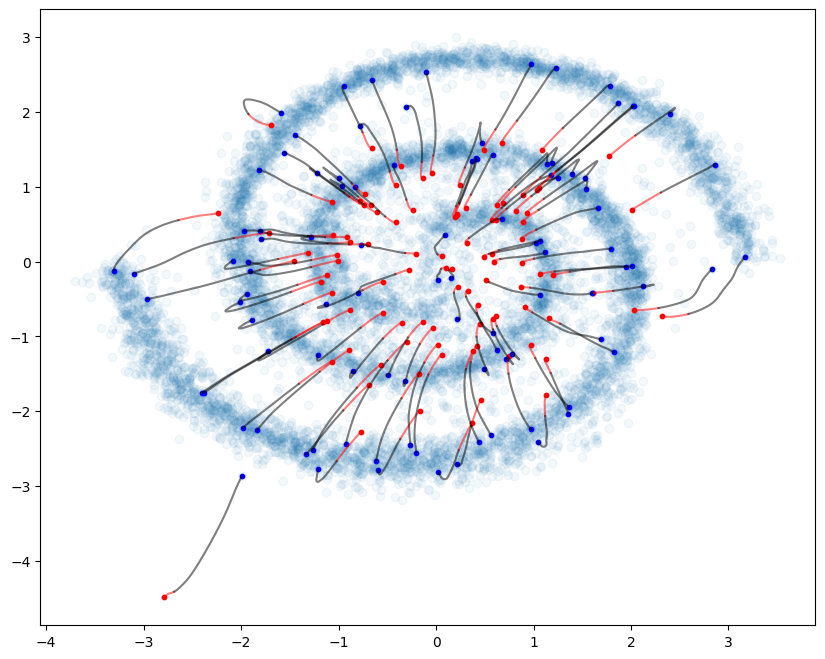

In [39]:
num_trajectories = 100

time_points = np.linspace(0,0.5,500)
plt.figure(figsize=(10,8))
plt.scatter(X1[:,0],X1[:,1],alpha = 0.05)

path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c = 'red',alpha = 0.5)

time_points = np.linspace(0.5,1.,500)
path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c='black',alpha = 0.5)

plt.scatter(X0[:num_trajectories,0],X0[:num_trajectories,1],c = 'red',s = 10.)

plt.scatter(X1[:num_trajectories,0],X1[:num_trajectories,1],c = 'blue',s = 10.)
plt.show()

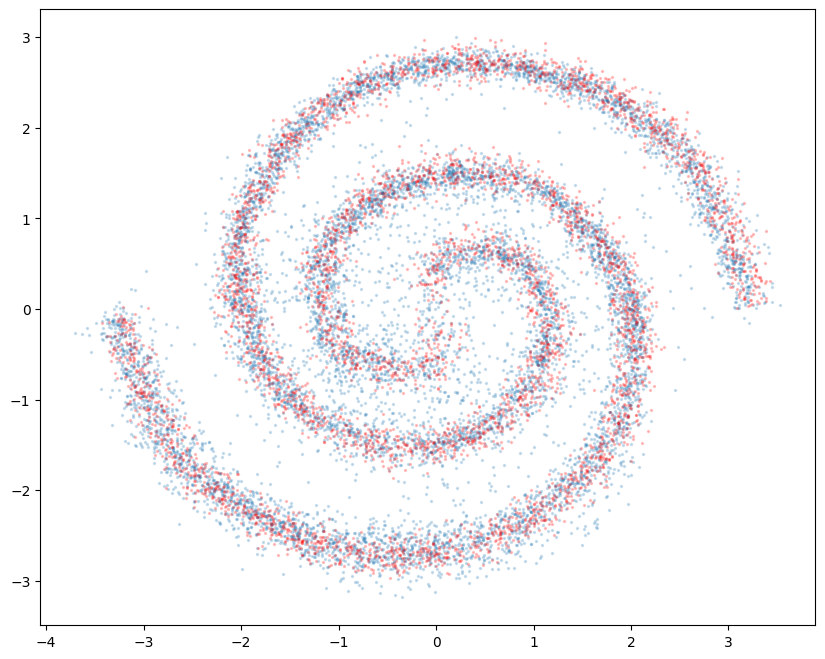

In [37]:
plt.figure(figsize=(10,8))
plt.scatter(X1[:,0],X1[:,1],alpha = 0.2, s = 2)
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.2,c = 'red', s = 2)